In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#Find the releative path of Lib folder
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import PyBEM2D as BEMpy

## BEM solution

[Mesh] Genetrated...
[Mesh] Discontinous Element used
[Mesh] Number of boundary elements:153(Total) 128(Edge) 24(Trace)
[Mesh] Number of Nodes:457(Total) 384(Edge) 72(Trace) 1(Source)
[Boundary Condition] BCs set up
[Boundary Condition] Dirichlet BC @ [(0, 0)]
[Boundary Condition] BCs set up
[Boundary Condition] Neumann BC @ [(2, <function NeumannBC_func at 0x000001728FBDCB70>)]
[Boundary Condition] BCs set up
[Boundary Condition] Dirichlet BC @ [(4, -5), (5, 3)]


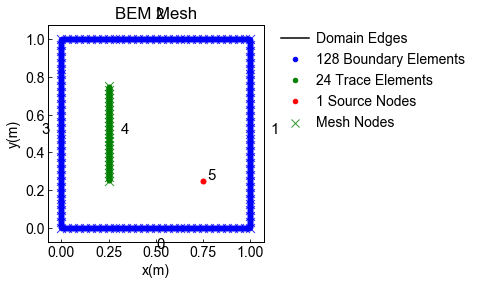

In [2]:
BEM_Case1=BEMpy.BEM2D()

#1.Build Mesh-#Anti-clock wise for internal domain
Boundary_vert=[(0.0, 0.0), (1.0, 0.0),(1.0,1.0),(0.0,1.0)] 

Trace_vert=[((0.25, 0.25), (0.25, 0.75))]

Source_vert=[(0.75,0.25)]

element_esize=1/32 #Edge mesh is important to overall mass balance
element_tszie=element_esize/1.5 #Trace mesh size

BEM_Case1.set_Mesh(Boundary_vert,Trace_vert,Source_vert,element_esize,element_tszie,Type="Quad")

#2.Set Boundary condition
bc0=[(0,0)]
BEM_Case1.set_BoundaryCondition(DirichletBC=bc0)

import numpy as np
def NeumannBC_func(Pts):
    #https://www.chegg.com/homework-help/questions-and-answers/2-solve-2d-steady-state-heat-conduction-equation-0-square-region-0-sx-s-1-0-sy-conditions--q24440992
    x,y=Pts[0],Pts[1]
    return 60*np.cos(4*np.pi*x)

bc_func=[(2,NeumannBC_func)]
BEM_Case1.set_BoundaryCondition(NeumannBC=bc_func,mode='func',update=1)

bc_sources=[(4,-5),(5,3)]
#bc_sources=[(4,-5)]
#bc_sources=[]
BEM_Case1.set_BoundaryCondition(DirichletBC=bc_sources,update=1)


#3.Set Domain Properties - permeability tensor
BEM_Case1.SetProps(k=3,miu=2)

#Check Mesh
BEM_Case1.plot_Mesh()
#Check Node,BC if necessary
#BEM_Case1.Mesh.print_debug()

[Solution] #DOFs= 457
[Visulization] Plotting Solution


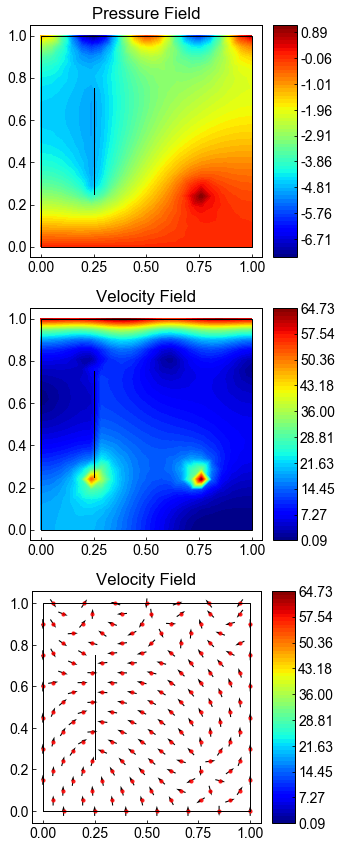

In [4]:
puv=BEM_Case1.Solve()
xx=BEM_Case1.PostProcess.plot_Solution()
#BEM_Case1.PostProcess.print_Solution()

In [5]:
P_refine,u_refine,v_refine=-2.394859708311529, -9.394556436960308, 1.8868599869558877
PUV=BEM_Case1.get_Solution((0.5,0.5))
Err_P=abs(PUV[0]-P_refine)/abs(P_refine)
Err_U=abs(PUV[1]-u_refine)/abs(u_refine) + abs(PUV[2]-v_refine)/v_refine

print("PUV",PUV)
print("Releative Err",Err_P,Err_U)

PUV (-2.9034462773089, -10.162919917552847, 5.0288483715005565)
Releative Err 0.2123659132233449 1.74698240089832


In [205]:
#BEM Solution
PUV=BEM_Case1.PostProcess.plot_Solution_overline(Pts1,Pts2,plot=False)
np.savetxt(".\\Verification\\UnitSquareBEM20_PUV.csv", PUV, delimiter=",")

In [215]:
#BEM Solution refine
PUV=BEM_Case1.PostProcess.plot_Solution_overline(Pts1,Pts2,plot=False)
np.savetxt(".\\Verification\\UnitSquareBEM97_PUV.csv", PUV, delimiter=",")

## Solution Verification

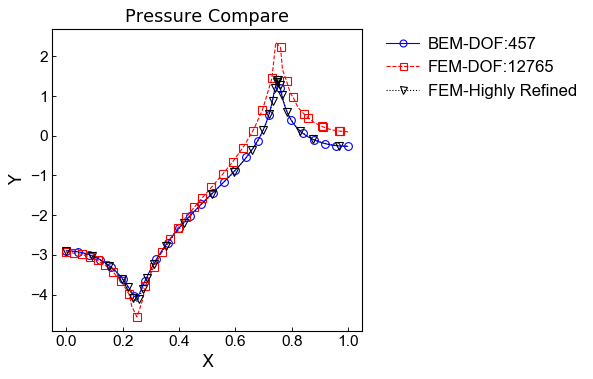

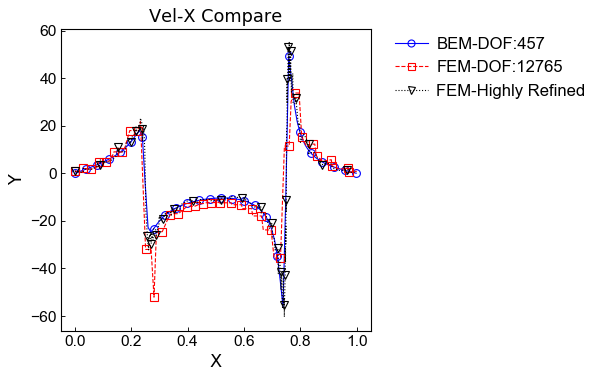

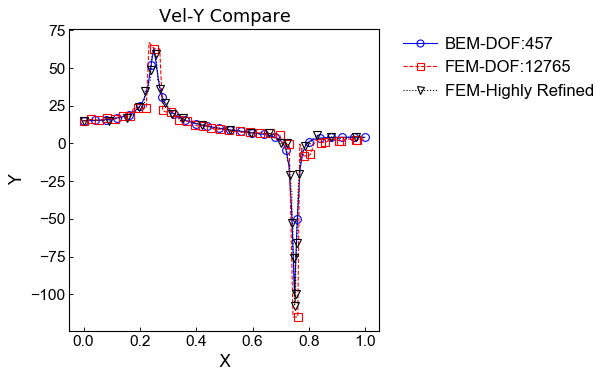

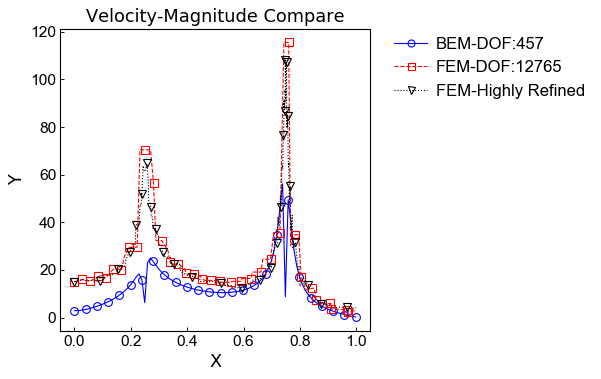

In [6]:
import numpy as np
tol=1e-3
Pts1,Pts2=(0.0+tol,0.24),(1.0-tol,0.24)

#BEM Solution
PUV=BEM_Case1.PostProcess.plot_Solution_overline(Pts1,Pts2,plot=False)

#Get Comsol Data
P_ref = np.genfromtxt('.\\Verification\\UnitSquareTS_p.csv', comments='%',delimiter=',')
u_ref = np.genfromtxt('.\\Verification\\UnitSquareTS_u.csv', comments='%',delimiter=',')
v_ref = np.genfromtxt('.\\Verification\\UnitSquareTS_v.csv', comments='%',delimiter=',')

#Get Comsol Data
P = np.genfromtxt('.\\Verification\\UnitSquareTS_pc.csv', comments='%',delimiter=',')
u = np.genfromtxt('.\\Verification\\UnitSquareTS_uc.csv', comments='%',delimiter=',')
v = np.genfromtxt('.\\Verification\\UnitSquareTS_vc.csv', comments='%',delimiter=',')

#Compare Pressure
DataNames=['BEM-DOF:%d'%(BEM_Case1.Mesh.Ndof),'FEM-DOF:12765','FEM-Highly Refined']
DataSetX=[PUV[:,0],P[:,0],P_ref[:,0]]

DataSetY=[PUV[:,1],P[:,1],P_ref[:,1]]
BEM_Case1.PostProcess.Compare_LinePlots(DataSetX,DataSetY,DataNames,'Pressure Compare')

DataSetY=[PUV[:,2],u[:,1],u_ref[:,1]]
BEM_Case1.PostProcess.Compare_LinePlots(DataSetX,DataSetY,DataNames,'Vel-X Compare')

DataSetY=[PUV[:,3],v[:,1],v_ref[:,1]]
BEM_Case1.PostProcess.Compare_LinePlots(DataSetX,DataSetY,DataNames,'Vel-Y Compare')

UMag_FEM_ref=np.sqrt(u_ref[:,1]*u_ref[:,1]+v_ref[:,1]*v_ref[:,1])
UMag_FEM=np.sqrt(u[:,1]*u[:,1]+v[:,1]*v[:,1])
UMag_BEM=np.sqrt(PUV[:,1]*PUV[:,1]+PUV[:,2]*PUV[:,2])
DataSetY=[UMag_BEM,UMag_FEM,UMag_FEM_ref]
BEM_Case1.PostProcess.Compare_LinePlots(DataSetX,DataSetY,DataNames,'Velocity-Magnitude Compare')

-----------------Pressure over line-----------------


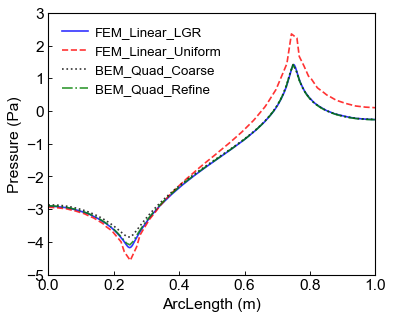

-----------------Velocity over line-----------------


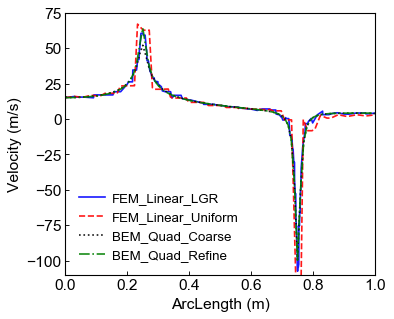

In [7]:
from utils import *

PFEM_uniform = np.genfromtxt('.\\Verification\\UnitSquareTS_pc.csv', comments='%',delimiter=',')
uFEM_uniform  = np.genfromtxt('.\\Verification\\UnitSquareTS_uc.csv', comments='%',delimiter=',')
vFEM_uniform  = np.genfromtxt('.\\Verification\\UnitSquareTS_vc.csv', comments='%',delimiter=',')

PFEM_LGR = np.genfromtxt('.\\Verification\\UnitSquareTS_p.csv', comments='%',delimiter=',')
uFEM_LGR  = np.genfromtxt('.\\Verification\\UnitSquareTS_u.csv', comments='%',delimiter=',')
vFEM_LGR  = np.genfromtxt('.\\Verification\\UnitSquareTS_v.csv', comments='%',delimiter=',')

PUV_BEM_coarse=np.genfromtxt('.\\Verification\\UnitSquareBEM20_PUV.csv', comments='%',delimiter=',')
PUV_BEM_refine=np.genfromtxt('.\\Verification\\UnitSquareBEM97_PUV.csv', comments='%',delimiter=',')


DataSetName=['FEM_Linear_LGR','FEM_Linear_Uniform','BEM_Quad_Coarse','BEM_Quad_Refine']
space=1
ArcLength=[PFEM_LGR[::space,0],PFEM_uniform[::space,0],PUV_BEM_coarse[::space,0],PUV_BEM_refine[::space,0]]
Pressure=[PFEM_LGR[::space,1],PFEM_uniform[::space,1],PUV_BEM_coarse[::space,1],PUV_BEM_refine[::space,1]]

print("-----------------Pressure over line-----------------")
plotTables(X=ArcLength,Y=Pressure, DataNames=DataSetName,
           XLable='ArcLength (m)',YLabel='Pressure (Pa)',Xlim=[0,1],Ylim=[-5,3],
           Alpha=[0.8]*len(DataSetName),
           MarkerSize=[0,0,0,0,0],LineWidth=[1.5,1.5,1.5,1.5,1.5],
           img_fname='Case2_PressureOverLine.pdf')


Velocity=[vFEM_LGR[::space,1],vFEM_uniform[::space,1],PUV_BEM_coarse[::space,3],PUV_BEM_refine[::space,3]]

print("-----------------Velocity over line-----------------")
plotTables(X=ArcLength,Y=Velocity, DataNames=DataSetName,
           XLable='ArcLength (m)',YLabel='Velocity (m/s)',Xlim=[0,1],Ylim=[-110,75],
           Alpha=[0.9]*len(DataSetName),
           MarkerSize=[0,0,0,0,0],LineWidth=[1.5,1.5,1.5,1.5,1.5],
           img_fname='Case2_VelocityYOverLine.pdf')

[Visulization] Plotting Solution


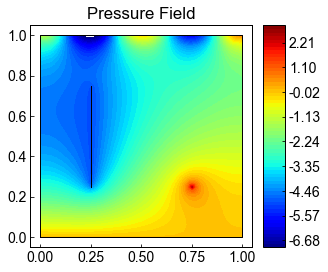

In [263]:
xx=BEM_Case1.PostProcess.plot_Solution(resolution=60,p_range=(-7,3),SubPlots=['P'],img_fname='Case2_Pressure_Field.pdf')

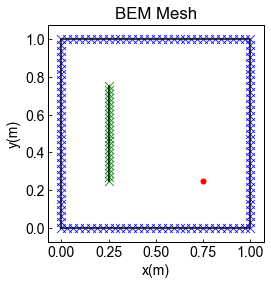

In [256]:
BEM_Case1.plot_Mesh(Annotation=0,legend=0,node_size=0,img_fname='Case2_BEM_Mesh_refine.pdf')

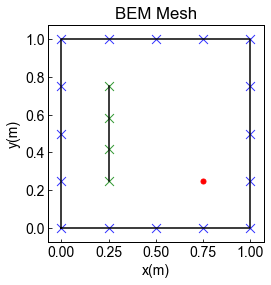

In [254]:
BEM_Case1.plot_Mesh(Annotation=0,legend=0,node_size=0,img_fname='Case2_BEM_Mesh.pdf')